# 【第２回目　課題３】PyTorchを使った深層学習 (3): MNIST編

Kerasでの分類問題の最初の練習として，手書き文字データセットであるMNISTの分類を行ってみます．
Yan LeCunが，最初にCNNの提案を行った論文中の実験で利用した歴史的なデータセットです．

0から9までの10文字です．28x28の大きさのグレースケールの文字画像が6万枚含まれます．

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# torchvision.datasetsを利用する場合は，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### <a href="https://pytorch.org/docs/stable/torchvision/datasets.html">データセットの自動読み込み</a>

MNIST, Cifar-10/100, Fashion-MNISTなど小規模なものからImageNetやKinetics-400など大規模なものまで，標準的な学習データセットを簡単に利用できる<a href="https://pytorch.org/docs/stable/torchvision/datasets.html">TorchVision Dataset</a>が用意されています．なお，TorchVisionは，Pytorchの画像認識向けの補助ライブラリで，標準的なデータセット，学習済モデル，データ拡張のためのメソッドなどが含まれています．
```python
trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)
```
download=True とすると，初回実行時には，自動的にダウンロードが行われます．（ですので，Proxyが必要な環境では，事前に環境変数を設定する必要があります．)

<a href="https://pytorch.org/docs/stable/torchvision/transforms.html">TorchVision Transforms</a>を利用することで，読み込み時にデータの変形をすることができます．以下のコードでは，<a href="https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor">ToTensor</a>を使って，HxWxCで[0,255]の整数値で表現されるPIL形式で読み込んだ画像をPyTorch Tensor形式 CxHxW の [0.0, 1.0]の実数に変換します．さらに，<a href="https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize">Normalize</a>を使って，Normalize((0.5),(0.5)) とすると，(x-0.5)/0.5 が行われて，[-1.0, 1.0] の値域に変換することもできます．

<a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader">torch.utils.data.DataLoader</a>は，データ読み込み用のクラスです．指定したbatchsize分のデータをまとめて取り出すことができます．また，num_worksを指定することで，マルチスレッドで高速なデータの受け渡しが可能となります．

In [2]:
import torchvision.transforms as transforms
import numpy as np

batch_size=200

# 画像をCHWの並びで，[-1.0,1.0]になるように変換
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 

trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)

# DataLoader で batchsize と 学習データに対してはepoch毎のランダムソート(shuffule)を指定．
# テストデータはshuffle不要で，MNISTは画像が小さいために，全部のテストデータがメモリに載るので　batchsize=データ数　とする．
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=10)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=10)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

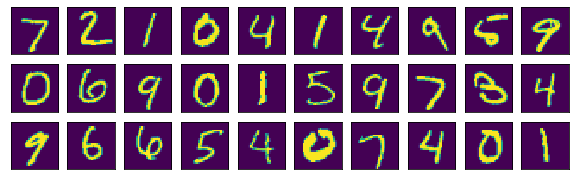

In [3]:
# MNISTデータの表示．テスト画像の最初の30枚を表示してみます．
sampset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True)
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    (img,label)=sampset.__getitem__(i)
    ax.imshow(img) 

In [4]:
# まずは，全結合2層だけで，分類してみます．

# Flatten は feature map (B,C,H,W) を vector (B,CHW) にする
# Pytorchには標準ではないので，定義しなくてはいけない．
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
model = nn.Sequential(
    Flatten(),#nn.Flatten()でも可
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
#    nn.Dropout2d(p=0.2),
    nn.ReLU(),
    nn.Linear(30, 10),
) 

print(model)
num=0
for param in model.parameters():
    num += param.numel()
print("total num. of params:",num)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=10, bias=True)
)
total num. of params: 81840


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# 複数GPU使用宣言  データが十分大きくないとあまり効果はない．MNISTでは使う意味はほとんどない．
# if torch.cuda.is_available() and torch.cuda.device_count()>1:
#     model = torch.nn.DataParallel(model) 

In [6]:
## model のグラフィカル表示．一度，forwardしないといけない．
#from torchviz import make_dot
#dummy = torch.zeros(1, 1, dtype=torch.float, requires_grad=False)
#dummy = torch.zeros(1, 28*28, dtype=torch.float)
#dummy = torch.zeros(1, 1, 28, 28, dtype=torch.float)
#out = model(dummy)
#make_dot(out)

学習中の経過のグラフ表示用にcallback用のShowGraphクラスを用意します．（ここは中身の理解不要．）

In [7]:
# callback のクラス ShowGraphを定義
class ShowGraph:
    def __init__(self,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.9, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 0.3 ])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.acc=[]
        self.acc_val=[]
        self.n_epoch=[]
        self.n_epoch_v=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, acc, vloss, vacc):
        self.n_epoch.append(epoch)
        self.n_epoch_v.append(epoch)
        self.acc.append(acc)
        self.acc_val.append(vacc)     
        self.losses.append(loss)
        self.losses_val.append(vloss)    
        self.test_acc=vacc
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch_v,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch_v,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    def on_epoch_train(self, epoch, loss, acc): # validationを評価しないepochの表示用
        self.n_epoch.append(epoch)
        self.acc.append(acc)
        self.losses.append(loss)
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
#        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
#        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
              
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("val_acc: ",self.test_acc) 
        print('Time: ',time.time()-self.start)

エポック数は25とする．

さらに，指定したエポックだけlossが改善しなかったら，学習率を下げる<a href="https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau">ReduceLROnPlateau</a> をここでは導入してみます．
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1,　patience=5, min_lr=0.0001)
```
としてみます．5epoch改善しなかったら，学習率を1/10にして，0.0001を学習率の下限とします．
(なお，Adamのような自動学習率調整機能がある最適化手法とは，通常は同時には使わないので注意してください．)

val_acc:  0.9757
Time:  78.9599871635437


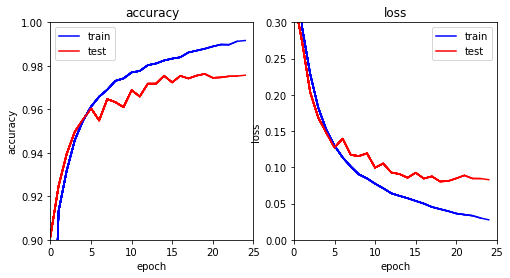

In [8]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
#optimizer = optim.Adam(model.parameters())
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

def train():
    loss=0
    total=0
    total0=0
    correct=0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        outputs = model(inputs.to(device))
        labels=labels.to(device)
        loss0= loss_fn(outputs, labels)
        loss+= loss0.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total0+=1
        correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()
    loss=loss/total0
    acc=correct/total 
    return loss, acc

def validate():
    with torch.no_grad():
         vloss=0
         total2=0
         total20=0
         correct2=0
         for (inputs, labels) in testloader:
             outputs = model(inputs.to(device))
             labels=labels.to(device)
             vloss += loss_fn(outputs, labels).item()
             _, predicted = torch.max(outputs.data, 1)#過学習予防
             total2 += labels.size(0)
             total20+=1
             correct2 += (predicted == labels).sum().item()
         vloss=vloss/total20
         vacc=correct2/total2
    return vloss, vacc   

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

では，次に畳み込み層を使ったネットワークを学習してみましょう．
del modelで一度モデルを消去してから，ネットワークを定義して，同じコードで再学習します．

Conv 3x3x20 + MaxPool + Conv 3x3x20 + FC としてみます．

In [9]:
del model

# 問題文では model2 と呼んでいる． 
model = nn.Sequential(
    nn.Conv2d(1,20,3, padding=1),
    nn.ReLU(),
    # nn.Dropout2d(p=5),
    # nn.BatchNorm2d(20),
    nn.MaxPool2d(2,2),
    nn.Conv2d(20,20,3, padding=1),
    nn.ReLU(),
    # nn.Dropout2d(p=5),
    # nn.BatchNorm2d(20),
    Flatten(),
    nn.Linear(3920, 10),
)

print(model)
num=0
for param in model.parameters():
    num += param.numel()
print("total num. of params:",num)
model = model.to(device)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Flatten()
  (6): Linear(in_features=3920, out_features=10, bias=True)
)
total num. of params: 43030


val_acc:  0.9891
Time:  80.19162273406982


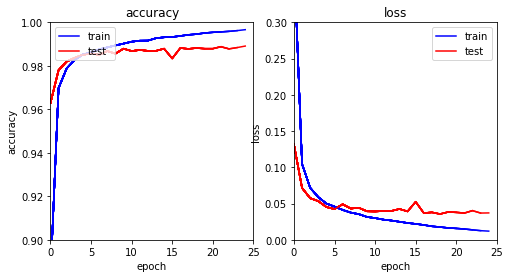

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

### 課題3
以下の小問の(1)-(3)を解答すること．(4)(5) は任意回答．

1. 全結合のみ(100, 30, 10)のmodel, 畳み込み(20, 20)＋全結合(10)のmodel2 のそれぞれのパラメータ数を計算し，全結合と畳み込みの違いをパラメータ数と認識性能の観点から考察せよ．
1. 学習のaccuracy/lossのグラフで青線(training), 赤線(validation)が乖離すると，過学習になっているとみなすことができる．それを解決するために，全結合のみのmodel, 畳み込み＋全結合のmodel2 のそれぞれにDropoutを追加するとどうなるか実験せよ．なお，modelには，2番目の全結合の後に0.2の割合で，model2には2つの畳み込みの直後に割合0.5でそれぞれ挿入せよ．(コメントアウトしてある行の # をとればよい．) (全結合はパラメータが多いので，0.5の割合で挿入する場合は epoch数を増やさないと十分に学習ができない．興味があれば試してみよ．)
1. model2に BatchNormalizationを追加せよ．その際，Dropoutを使ったほうがいいか，使わないほうがいいか比較せよ．
1. OptimizerをAdamに変更して，MomentumSDGとの結果の違いを観察せよ．
1. DataLoaderのnum_worksの値を0,5,10,20に変更して，学習時間を比較せよ．

## ドロップアウトを追加したものとその結果である。

全結合のみのパラメータ数は81840、畳み込み+全結合のパラメータ数は43030である。しかし、後者の方が精度が高いことから、後者のほうがより画像の認識における特長量を効率よく認識できる形式であり、パラメータを抑えられると考えられる。

## ドロップアウトを追加したものとその結果である。

In [11]:
# まずは，全結合2層だけで，分類してみます．

# Flatten は feature map (B,C,H,W) を vector (B,CHW) にする
# Pytorchには標準ではないので，定義しなくてはいけない．
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
model = nn.Sequential(
    Flatten(),#nn.Flatten()でも可
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.Dropout2d(p=0.2),
    nn.ReLU(),
    nn.Linear(30, 10),
) 

print(model)
num=0
for param in model.parameters():
    num += param.numel()
print("total num. of params:",num)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=30, bias=True)
  (4): Dropout2d(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=30, out_features=10, bias=True)
)
total num. of params: 81840


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# 複数GPU使用宣言  データが十分大きくないとあまり効果はない．MNISTでは使う意味はほとんどない．
# if torch.cuda.is_available() and torch.cuda.device_count()>1:
#     model = torch.nn.DataParallel(model) 

val_acc:  0.9695
Time:  79.93299961090088


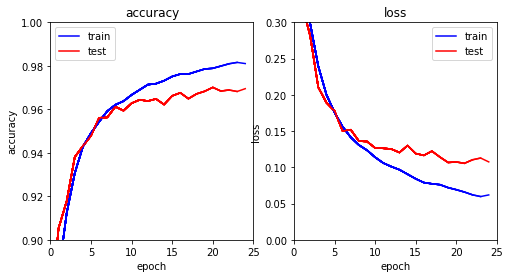

In [13]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
#optimizer = optim.Adam(model.parameters())
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

def train():
    loss=0
    total=0
    total0=0
    correct=0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        outputs = model(inputs.to(device))
        labels=labels.to(device)
        loss0= loss_fn(outputs, labels)
        loss+= loss0.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total0+=1
        correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()
    loss=loss/total0
    acc=correct/total 
    return loss, acc

def validate():
    with torch.no_grad():
         vloss=0
         total2=0
         total20=0
         correct2=0
         for (inputs, labels) in testloader:
             outputs = model(inputs.to(device))
             labels=labels.to(device)
             vloss += loss_fn(outputs, labels).item()
             _, predicted = torch.max(outputs.data, 1)#過学習予防
             total2 += labels.size(0)
             total20+=1
             correct2 += (predicted == labels).sum().item()
         vloss=vloss/total20
         vacc=correct2/total2
    return vloss, vacc   

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

ドロップアウトによって、過学習が抑制されることが確認された。

## バッチノーマライズを追加したものとその結果である。

In [14]:
del model

# 問題文では model2 と呼んでいる． 
model = nn.Sequential(
    nn.Conv2d(1,20,3, padding=1),
    nn.ReLU(),
    nn.Dropout2d(p=0.5),
nn.BatchNorm2d(20),
    nn.MaxPool2d(2,2),
    nn.Conv2d(20,20,3, padding=1),
    nn.ReLU(),
    nn.Dropout2d(p=0.5),
    # nn.BatchNorm2d(20),
    Flatten(),
    nn.Linear(3920, 10),
)

print(model)
num=0
for param in model.parameters():
    num += param.numel()
print("total num. of params:",num)
model = model.to(device)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Dropout2d(p=0.5, inplace=False)
  (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Dropout2d(p=0.5, inplace=False)
  (8): Flatten()
  (9): Linear(in_features=3920, out_features=10, bias=True)
)
total num. of params: 43070


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

val_acc:  0.9797
Time:  81.90037488937378


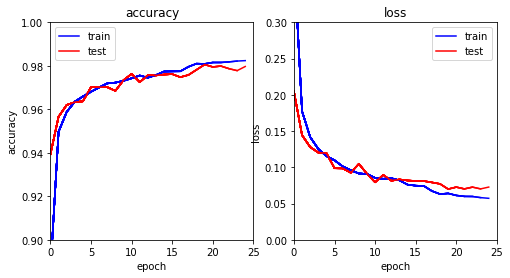

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

In [17]:
del model

# 問題文では model2 と呼んでいる． 
model = nn.Sequential(
    nn.Conv2d(1,20,3, padding=1),
    nn.ReLU(),
    nn.Dropout2d(p=0.5),
    nn.BatchNorm2d(20),
    nn.MaxPool2d(2,2),
    nn.Conv2d(20,20,3, padding=1),
    nn.ReLU(),
    nn.Dropout2d(p=0.5),
    nn.BatchNorm2d(20),
    Flatten(),
    nn.Linear(3920, 10),
)

print(model)
num=0
for param in model.parameters():
    num += param.numel()
print("total num. of params:",num)
model = model.to(device)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Dropout2d(p=0.5, inplace=False)
  (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Dropout2d(p=0.5, inplace=False)
  (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Flatten()
  (10): Linear(in_features=3920, out_features=10, bias=True)
)
total num. of params: 43110


In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

val_acc:  0.9744
Time:  82.22764801979065


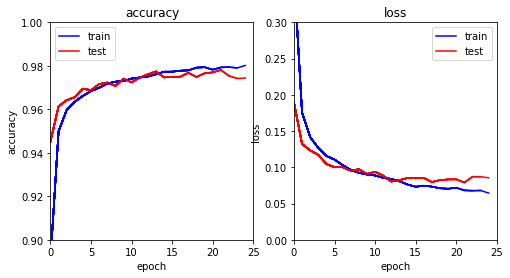

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

バッチノーマライズにより、過学習が抑制されることが確認された。また、ドロップアウトと併用した際には精度の悪化が見られたのに対して、過学習の抑制効果はあまり見られなかったため、併用すべきではないと考えられる。